In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchinfo import summary


class MullerResizer(nn.Module):
    """Learned Laplacian resizer in PyTorch, fixed Gaussian blur for channel handling."""
    def __init__(self, base_resize_method='bilinear', antialias=False,
                 kernel_size=5, stddev=1.0, num_layers=2, avg_pool=False,
                 dtype=torch.float32, init_weights=None, name='muller_resizer'):
        super(MullerResizer, self).__init__()
        self.name = name
        self.base_resize_method = base_resize_method
        self.antialias = antialias  # Note: PyTorch does not support antialiasing in resizing.
        self.kernel_size = kernel_size
        self.stddev = stddev
        self.num_layers = num_layers
        self.avg_pool = avg_pool
        self.dtype = dtype

        self.weights = nn.ParameterList()
        self.biases = nn.ParameterList()
        for layer in range(num_layers):
            weight = nn.Parameter(torch.zeros(1, dtype=dtype) if init_weights is None else torch.tensor([init_weights[2*layer]], dtype=dtype))
            bias = nn.Parameter(torch.zeros(1, dtype=dtype) if init_weights is None else torch.tensor([init_weights[2*layer+1]], dtype=dtype))
            self.weights.append(weight)
            self.biases.append(bias)

    def _base_resizer(self, inputs, target_size):
        if self.avg_pool:
            stride_h = inputs.shape[2] // target_size[0]
            stride_w = inputs.shape[3] // target_size[1]
            if stride_h > 1 and stride_w > 1:
                inputs = F.avg_pool2d(inputs, kernel_size=(stride_h, stride_w), stride=(stride_h, stride_w))
        return F.interpolate(inputs, size=target_size, mode=self.base_resize_method)

    def _gaussian_blur(self, inputs):
        sigma = max(self.stddev, 0.1)  # Ensure sigma is not too small
        radius = self.kernel_size // 2
        kernel_size = 2 * radius + 1
        x_coord = torch.arange(kernel_size, dtype=inputs.dtype, device=inputs.device) - radius
        y_grid = x_coord.repeat(kernel_size, 1)
        x_grid = x_coord.view(-1, 1).repeat(1, kernel_size)
        xy_grid = torch.sqrt(x_grid**2 + y_grid**2)
        kernel = torch.exp(-xy_grid**2 / (2 * sigma**2))
        kernel_sum = kernel.sum()
        if kernel_sum.item() == 0:
            kernel += 1e-10  # Ensure kernel sum is not zero to avoid division by zero
        kernel /= kernel_sum

        kernel = kernel.view(1, 1, kernel_size, kernel_size).repeat(inputs.shape[1], 1, 1, 1)
        blurred = F.conv2d(inputs, kernel, padding=radius, groups=inputs.shape[1])
        return blurred


    def forward(self, inputs, target_size):
        inputs = inputs.to(dtype=self.dtype)
        net = self._base_resizer(inputs, target_size)
        for weight, bias in zip(self.weights, self.biases):
            blurred = self._gaussian_blur(inputs)
            residual_image = blurred - inputs
            resized_residual = self._base_resizer(residual_image, target_size)
            # Ensure the scaling factor does not cause instability
            scaled_residual = weight * resized_residual + bias
            # Use safe activation to ensure no extreme values
            net += torch.tanh(scaled_residual.clamp(min=-3, max=3))  # Clamping to prevent extreme values
            inputs = blurred
        return net



config = {
  # "target_size": (1024, 1024),
  "base_resize_method": "bilinear",
  "antialias": False,
  "kernel_size": 5,
  "stddev": 1.0,
  "num_layers": 2,
  "avg_pool": False,
  "dtype": torch.float32,
  "name": 'muller_resizer',
  "init_weights": [1.892, -0.014, -11.295, 0.003],  # pre-trained weights for ResNet-50
}

resizer = MullerResizer(
    # target_size=config["target_size"],
    base_resize_method=config["base_resize_method"],
    antialias=config["antialias"],
    kernel_size=config["kernel_size"],
    stddev=config["stddev"],
    num_layers=config["num_layers"],
    avg_pool=config["avg_pool"],
    dtype=config["dtype"],
    init_weights=config["init_weights"],
    name=config["name"]
)

input_tensor = torch.rand(1, 3, 128, 128)


output = resizer(input_tensor,(1024, 1024))

print("Output size:", output.size())


# print(summary(resizer, input_tensor.size()))

Output size: torch.Size([1, 3, 1024, 1024])


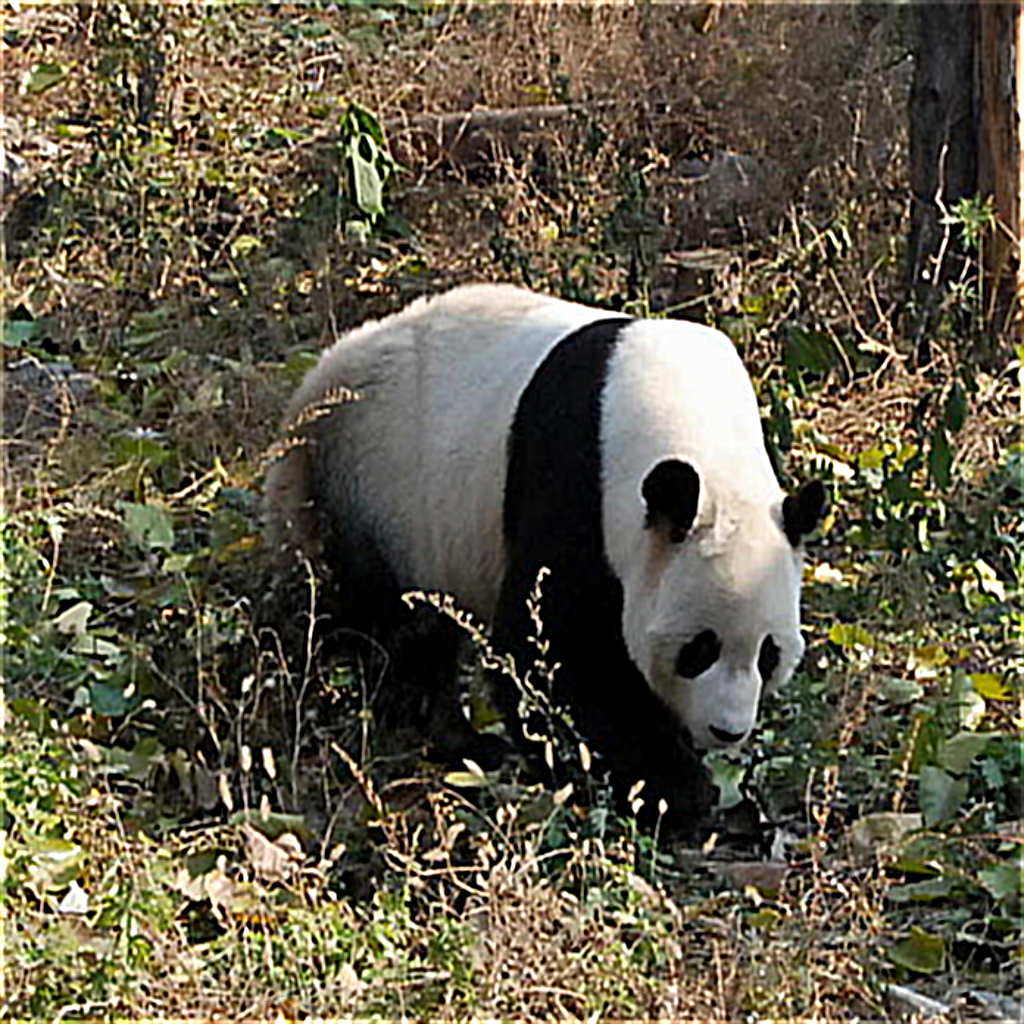

In [10]:
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms

url = "https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

response = requests.get(url, headers=headers)


image = Image.open(BytesIO(response.content)).convert("RGB")
image.show()  

transform = transforms.Compose([
    transforms.ToTensor()
])
input_tensor = transform(image).unsqueeze(0)  


output_tensor = resizer(input_tensor,(1024, 1024))
output_tensor = torch.clamp(output_tensor, 0, 1)

output_image = transforms.ToPILImage()(output_tensor.squeeze(0))
output_image
